In [1]:
import bayes3d as b
import os
import jax.numpy as jnp
import jax
import bayes3d.genjax
import genjax
import matplotlib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import flax.linen as nn
from flax.training.train_state import TrainState
from clu import metrics
import flax
import optax

In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/


In [4]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

b.setup_renderer(intrinsics)
# model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
# meshes = []
# for idx in range(1,22):
#     mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
#     b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [5]:
fork_mesh_path = b.utils.get_assets_dir() + '/ycb_video_models/models/030_fork/nontextured.ply'
knife_mesh_path = b.utils.get_assets_dir() + '/ycb_video_models/models/032_knife/nontextured.ply'
box_mesh_path = b.utils.get_assets_dir() + '/bop/ycbv/models/obj_000002.ply'
table_mesh_path = b.utils.get_assets_dir() + '/sample_objs/cube.obj'
fork_scale = knife_scale = 1.0
box_scale = 1e-3
table_scale = 1e-6
mesh_paths = (fork_mesh_path, knife_mesh_path, box_mesh_path, table_mesh_path)
scales = (fork_scale, knife_scale, box_scale, table_scale)
for mesh_path, scale in zip(mesh_paths, scales):
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=scale)

Centering mesh with translation [-0.02541  -0.022295  0.007042]
Centering mesh with translation [-0.019428  -0.0274155  0.003918 ]


In [6]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.7, 0.5]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

In [7]:
FORK_IDX, KNIFE_IDX, CHEESEITZ_BOX_IDX, TABLE_IDX = 0, 1, 2, 3

In [8]:
SHIFT_MIN = -0.2
SHIFT_SCALE = 0.4
CHEESEITZ_BOX_CONTACT_PARAMS = jnp.array([0.0, 0.1, 0.0])

In [9]:
def fork_spoon_from_known_params(is_fork, shift):
    indices = jax.lax.cond(is_fork,
                           lambda: jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, FORK_IDX]),
                           lambda: jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, KNIFE_IDX]))

    box_dims = b.RENDERER.model_box_dims[indices]
    root_poses = jnp.array([table_pose, table_pose, table_pose])
    parents = jnp.array([-1, 0, 0])
    contact_params = jnp.array([[0.0, 0.0, 0.0],
                                [*CHEESEITZ_BOX_CONTACT_PARAMS],
                                [shift*jnp.cos(jnp.pi/12), -0.05 + shift*jnp.sin(jnp.pi/12), 10*jnp.pi/12]])
    faces_parents = jnp.array([0, 2, 2])
    faces_child = jnp.array([0, 3, 3])
    poses = b.scene_graph.poses_from_scene_graph(
        root_poses, box_dims, parents, contact_params, faces_parents, faces_child)
    camera_pose = jnp.eye(4)
    rendered = b.RENDERER.render(
        jnp.linalg.inv(camera_pose) @ poses , indices
    )[...,:3]
    return (is_fork, rendered)

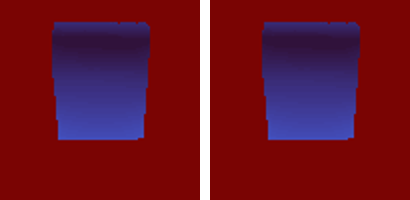

In [10]:
ss = 0.06
b.viz.hstack_images([b.viz.scale_image(b.get_depth_image(fork_spoon_from_known_params(True, ss)[1][...,2]), 2),
                     b.viz.scale_image(b.get_depth_image(fork_spoon_from_known_params(False, ss)[1][...,2]), 2)])

In [11]:
def fork_spoon_generator(key):
    is_fork_key, shift_key = jax.random.split(key, 2)
    is_fork = jax.random.bernoulli(is_fork_key)
    shift = SHIFT_MIN + SHIFT_SCALE * jax.random.uniform(shift_key)

    return fork_spoon_from_known_params(is_fork, shift)

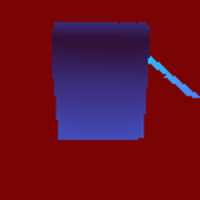

In [12]:
b.viz.scale_image(b.get_depth_image(fork_spoon_generator(jax.random.PRNGKey(0))[1][...,2]), 2)

## CNN Inference

C1: conv with 10x10 filter stride 3 32 channels (input 100x100x1, output 31 x 31 x 32)

relu (input 31 x 31 x 32, output 31 x 31 x 32)

max pooling 3x3 stride 2 32 channels (input 31 x 31 x 32, output 15 x 15x 32)

C2: conv with 5x5 filter stride 2 64 channels (input 15 x 15 x 32, output 6 x 6 x 64)

relu (input 6 x 6 x 64, output 6 x 6 x 64)

max pooling 2x2 stride 2 64 channels (input 6 x 6 x 64, output 3 x 3 x 64)

flatten (input 3 x 3 x 64, output 1 x 576)

L1: linear (input 1 x 576, output 1x 576)

relu

L2: linear (input 1 x 576, output 1x 192)

relu

L3: linear (input 1 x 192, output 1x 24)

relu

L4: linear (input 1 x 24, output 1 x 2)

softmax

In [13]:
class CNN(nn.Module):

    @nn.compact
    def __call__(self, imgs): # XXX todo: make sure the sizes all line up
        c1 = nn.Conv(32, (10, 10), strides=(3, 3), padding='VALID')(imgs)
        r1 = nn.activation.relu(c1)
        m1 = nn.max_pool(r1, (3, 3), strides=(2, 2))
        
        c2 = nn.Conv(64, (5, 5), strides=(2, 2), padding='VALID')(m1)
        r2 = nn.activation.relu(c2)
        m2 = nn.max_pool(r2, (2, 2), strides=(2, 2))
        
        l1 = nn.Dense(576)(m2.reshape(imgs.shape[0], -1))
        r3 = nn.activation.relu(l1)

        l2 = nn.Dense(192)(r3)
        r4 = nn.activation.relu(l2)

        l3 = nn.Dense(24)(r4)
        r5 = nn.activation.relu(l3)

        l4 = nn.Dense(2)(r5)
        return l4 # nn.activation.softmax(l4)

In [14]:
cnn = CNN()
cnn.tabulate(jax.random.PRNGKey(0), jnp.zeros((1, 100, 100, 1)), console_kwargs={'force_jupyter': True})

                                          CNN Summary                                          
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs               ┃ outputs             ┃ params                      ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[1,100,100,1] │ float32[1,2]        │                             │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Conv_0  │ Conv   │ float32[1,100,100,1] │ float32[1,31,31,32] │ bias: float32[32]           │
│         │        │                      │                     │ kernel: float32[10,10,1,32] │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 3,232 (12.9 KB)             │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Conv_1  │ Conv   │ float32[1,15,15,32]  │ float32[1,6,6,64]   │ bias: float32[64]           │
│         │        │                      │                     │ kernel: float32[5,5,32,64]  │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 51,264 (205.1 KB)           │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_0 │ Dense  │ float32[1,576]       │ float32[1,576]      │ bias: float32[576]          │
│         │        │                      │                     │ kernel: float32[576,576]    │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 332,352 (1.3 MB)            │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_1 │ Dense  │ float32[1,576]       │ float32[1,192]      │ bias: float32[192]          │
│         │        │                      │                     │ kernel: float32[576,192]    │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 110,784 (443.1 KB)          │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_2 │ Dense  │ float32[1,192]       │ float32[1,24]       │ bias: float32[24]           │
│         │        │                      │                     │ kernel: float32[192,24]     │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 4,632 (18.5 KB)             │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_3 │ Dense  │ float32[1,24]        │ float32[1,2]        │ bias: float32[2]            │
│         │        │                      │                     │ kernel: float32[24,2]       │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 50 (200 B)                  │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│         │        │                      │               Total │ 502,314 (2.0 MB)            │
└─────────┴────────┴──────────────────────┴─────────────────────┴─────────────────────────────┘
                                                                                               
                              Total Parameters: 502,314 (2.0 MB)                               

'\n\n'

In [15]:
def create_train_state(module, rng, learning_rate, momentum):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones([BATCH_SIZE, 100, 100, 1]))['params'] # initialize parameters by passing a template image
    tx = optax.sgd(learning_rate, momentum)
    return TrainState.create(apply_fn=module.apply, params=params, tx=tx)

In [16]:
make_onehot = lambda b: jax.lax.cond(b, lambda: jnp.array([0.0, 1.0]), lambda: jnp.array([1.0, 0.0]))

In [17]:
@jax.jit
def make_batch(batch_keys):
    is_forks, imgs = zip(*map(fork_spoon_generator, batch_keys))
    img_batch = jnp.concatenate([img[:,:,2].reshape(1, 100, 100, 1) for img in imgs], 0)
    label_batch = jnp.array([make_onehot(is_fork) for is_fork in is_forks])
    return img_batch, label_batch

In [18]:
@jax.jit
def train_step(state, img_batch, label_batch): 
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, img_batch)
        loss = optax.softmax_cross_entropy(logits=logits, labels=label_batch).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss_fn(state.params)

In [19]:
@jax.jit
def calc_loss(train_state, dataset_keys):
    img_batch, label_batch = make_batch(dataset_keys)
    return optax.softmax_cross_entropy(
        logits= train_state.apply_fn({'params': train_state.params}, img_batch),
        labels=label_batch).mean()

def calc_loss_batched(train_state, dataset_keys):
    n_batches = dataset_keys.shape[0] // BATCH_SIZE
    return jnp.array([calc_loss(train_state, batch)
                      for batch in dataset_keys.reshape(n_batches, BATCH_SIZE, 2)]).mean()

In [20]:
N_TRAIN = 30000
N_TEST = 1000
N_EPOCHS = 10
BATCH_SIZE = 100
LEARNING_RATE = 0.02
MOMENTUM = 0.9
assert N_TRAIN % BATCH_SIZE == 0
assert N_TEST % BATCH_SIZE == 0

In [21]:
state = create_train_state(cnn, jax.random.PRNGKey(0), LEARNING_RATE, MOMENTUM)

In [22]:
train_keys = jax.random.split(jax.random.PRNGKey(0), N_TRAIN)
test_keys = jax.random.split(jax.random.PRNGKey(2718), N_TEST)
shuffling_key = jax.random.PRNGKey(0)

In [23]:
training_losses = []

In [25]:
for epoch in range(N_EPOCHS):
    training_losses.append([])
    epoch_keys = jax.random.permutation(shuffling_key, train_keys)
    shuffling_key = jax.random.split(shuffling_key, 2)[1]

    assert N_TRAIN % BATCH_SIZE == 0
    for step in range(N_TRAIN // BATCH_SIZE):
        batch_keys = epoch_keys[step*BATCH_SIZE:(1+step)*BATCH_SIZE]
        img_batch, label_batch = make_batch(batch_keys)
        
        state, loss = train_step(state, img_batch, label_batch) 
        training_losses[-1].append(loss)
        print('.', end='')
    print()

    epoch_loss = jnp.array(training_losses[-1]).mean()
    #epoch_train_loss = calc_loss_batched(state, train_keys)
    #epoch_test_loss = calc_loss_batched(state, test_keys)
    epoch_train_loss = 'not calculated'
    epoch_test_loss = 'not calculated'
    print(f'epoch: {epoch}, average loss: {epoch_loss}, '
          f'train loss: {epoch_train_loss}, '
          f'test loss: {epoch_test_loss}')

2023-08-31 19:02:48.999376: W external/xla/xla/service/gpu/runtime/support.cc:58] Intercepted XLA runtime error:
UNKNOWN: jax_rasterize_fwd_gl XLA extension have thrown an exception: Cuda error: 999[cudaGraphicsGLRegisterImage(&s.cudaPoseTexture, s.glPoseTexture, GL_TEXTURE_2D, cudaGraphicsRegisterFlagsReadOnly);]
Exception raised from _rasterize_fwd_gl at /home/matin/bayes3d/bayes3d/_rendering/nvdiffrast/common/rasterize_gl.cpp:494 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x57 (0x7f78541db4d7 in /opt/conda/envs/bayes3d/lib/python3.9/site-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7f78541a536b in /opt/conda/envs/bayes3d/lib/python3.9/site-packages/torch/lib/libc10.so)
frame #2: _rasterize_fwd_gl(CUstream_st*, RasterizeGLStateWrapper&, float const*, unsigned int, unsigned int, std::vector<float, std::allocator<float> > const&, std::vector<int, s

ValueError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: jax_rasterize_fwd_gl XLA extension have thrown an exception: Cuda error: 999[cudaGraphicsGLRegisterImage(&s.cudaPoseTexture, s.glPoseTexture, GL_TEXTURE_2D, cudaGraphicsRegisterFlagsReadOnly);]
Exception raised from _rasterize_fwd_gl at /home/matin/bayes3d/bayes3d/_rendering/nvdiffrast/common/rasterize_gl.cpp:494 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x57 (0x7f78541db4d7 in /opt/conda/envs/bayes3d/lib/python3.9/site-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7f78541a536b in /opt/conda/envs/bayes3d/lib/python3.9/site-packages/torch/lib/libc10.so)
frame #2: _rasterize_fwd_gl(CUstream_st*, RasterizeGLStateWrapper&, float const*, unsigned int, unsigned int, std::vector<float, std::allocator<float> > const&, std::vector<int, std::allocator<int> > const&, void*) + 0x434 (0x7f78103c58a3 in /home/matin/.cache/torch_extensions/py39_cu118/nvdiffrast_plugin_gl/nvdiffrast_plugin_gl.so)
frame #3: jax_rasterize_fwd_gl(CUstream_st*, void**, char const*, unsigned long) + 0x205 (0x7f78103c6a67 in /home/matin/.cache/torch_extensions/py39_cu118/nvdiffrast_plugin_gl/nvdiffrast_plugin_gl.so)
frame #4: <unknown function> + 0x2df1ff1 (0x7f790a7e9ff1 in /opt/conda/envs/bayes3d/lib/python3.9/site-packages/jaxlib/xla_extension.so)
frame #5: <unknown function> + 0x2df2d02 (0x7f790a7ead02 in /opt/conda/envs/bayes3d/lib/python3.9/site-packages/jaxlib/xla_extension.so)
frame #6: [0x7f737e79c65c]
; current tracing scope: custom-call.1082; current profiling annotation: XlaModule:#hlo_module=jit_make_batch,program_id=539#.

In [ ]:
#plt.plot(training_losses)

In [ ]:
img_batch, label_batch = make_batch(batch_keys)
logits = state.apply_fn({'params': state.params}, img_batch)

In [ ]:
i = 33 #23 # 13

In [ ]:
b.viz.scale_image(b.get_depth_image(img_batch[i, :, :, 0]), 2)

In [ ]:
label_batch[i], jax.nn.softmax(logits[i])